# Demystifying Recurrent Neural Network

### Hand Designing an LSTM
1. What do we want to keep? - it seems like we only need h<sub>t-1</sub> and new x to predict h<sub>1</sub>. 
2. How to configure the forget gate?
3. h = tanh(...) = [-1,1]

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Plot styling
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13

def np_sigmoid(x):
  return 1/(1 + np.exp(-x))


x = np.arange(-5,5,0.1)
plt.plot(x, np.tanh(x), label="tanh(x)")
plt.plot(x, np_sigmoid(x), label="sigmoid(x)")
plt.axhline(y=0, color="black")
plt.axvline(x=0, color="black")
plt.axvline(x=-1, color="black")
plt.axvline(x=1, color="black")
plt.legend()
plt.show()

In [ ]:
# from univariate_tester import test_parity_lstm
import numpy as np
import itertools
import pandas as pd

def s(x):
  return 1/(1 + np.exp(-x))

def test_parity_lstm(w_ix = 0, w_ih = 0, b_i = 0, 
                     w_fx = 0, w_fh = 0, b_f = 0,
                     w_ox = 0, w_oh = 0, b_o = 0,
                     w_gx = 0, w_gh = 0, b_g = 0):
    cnt = 0
    
    i_list = []
    f_list = []
    g_list = []
    o_list = []
    c_list = []
    h_list = []
    
    # for X in itertools.product([0,1], repeat=14):
    for X in [(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1)]:
        c = 0
        h = 0
        for x in X:
            i = s(w_ih*h + w_ix*x + b_i)    # input gate layer
            f = s(w_fh*h + w_fx*x + b_f)    # forget gate layer
            g = np.tanh(w_gh*h + w_gx*x + b_g)  # cell gate
            o = s(w_oh*h + w_ox*x + b_o)    # output
            c = f*c + i*g                   # cell state
            h = o*np.tanh(c)                # filtered output
            
            i_list.append(i)
            f_list.append(f)
            g_list.append(g)
            o_list.append(o)
            c_list.append(c)
            h_list.append(h)
            
        if np.sum(X)%2 != int(h>0.5):
            print("Failure", cnt, X, ", sum(X) =", np.sum(X), ", h =", "%.02f" % h, 
                  np.sum(X)%2 == int(h>0.5))
            break
        if cnt % 1000 == 0:
            print(cnt)
            
        cnt += 1
    
    history = pd.DataFrame()
    history['i'] = i_list
    history['f'] = f_list
    history['g'] = g_list
    history['o'] = o_list
    history['c'] = c_list
    history['h'] = h_list
    
    print(history)

test_parity_lstm(w_ix = 3, w_ih = -3, b_i = -0.5, 
                w_fx = 0, w_fh = 1, b_f = 0,
                w_ox = 1, w_oh = 1, b_o = 0,
                w_gx = 3, w_gh = -3, b_g = 2)

# Learning to Copy Finite State Machines

### Parity: Examining Generalization To Longer Sequences

In [1]:
import torch
from driver_parity import ParityLSTM, Parity, pad_collate
from torch.utils.data import Dataset, DataLoader

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Build the model and put it on the GPU
model = ParityLSTM()
model.to(dev) # move to GPU if cuda is enabled


maximum_training_sequence_length = 5
train = Parity(split='train', max_length=maximum_training_sequence_length)
train_loader = DataLoader(train, batch_size=100, shuffle=True, collate_fn=pad_collate)

/Users/johnnybui/opt/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
from driver_parity import train_model

acc = 0

while acc < 0.9:
    train_losses, train_acc = train_model(model, train_loader, epochs=2000, lr=0.0005)
    acc = list(train_acc.values())[-1]

In [22]:
# Basic python imports for logging and sequence generation
import itertools
import random
import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')


# Imports for Pytorch for the things we need
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import torch.nn as nn
import torch.nn.functional as F

class SimpleClassifier(torch.nn.Module):
    def __init__(self, insize, outsize, hidden=128):
        super().__init__()
        self.linear = nn.Linear(insize, 128)
        self.linear2 = nn.Linear(128,outsize)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight)
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0.5)

    def forward(self, x):
        out = F.relu(self.linear(x))
        out = F.dropout(out,0.5)
        out = self.linear2(out)
        out = torch.sigmoid(out)
        return out

class ParityLSTM(torch.nn.Module) :

    # __init__ builds the internal components of the model (presumably an LSTM and linear layer for classification)
    # The LSTM should have hidden dimension equal to hidden_dim

    def __init__(self, hidden_dim=64) :
        super().__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.classifier = SimpleClassifier(hidden_dim, 2)
    
    # forward runs the model on an B x max_length x 1 tensor and outputs a B x 2 tensor representing a score for 
    # even/odd parity for each element of th ebatch
    # 
    # Inputs:
    #   x -- a batch_size x max_length x 1 binary tensor. This has been padded with zeros to the max length of 
    #        any sequence in the batch.
    #   s -- a batch_size x 1 list of sequence lengths. This is useful for ensuring you get the hidden state at 
    #        the end of a sequence, not at the end of the padding
    #
    # Output:
    #   out -- a batch_size x 2 tensor of scores for even/odd parity    

    def forward(self, x, s):
        N = len(s)
        max_len = max(s)
        
        # s = torch.Tensor(s)
        
        x_pack = pack_padded_sequence(x.view(N, max_len, 1), s, batch_first=True, enforce_sorted=False)
        
        out, (hn, cn) = self.lstm(x_pack)
        out = self.classifier(hn[-1]).view(N, 2)
        
        return out

    def __str__(self):
        return "LSTM-"+str(self.hidden_dim)
    
class Parity(Dataset):

    def __init__(self,split="train", max_length=4):
      if split=="train":
        self.data = []
        for i in range(1,max_length+1):
          self.data += [torch.FloatTensor(seq) for seq in itertools.product([0,1], repeat=i)]
      else:
        self.data = [torch.FloatTensor(seq) for seq in itertools.product([0,1], repeat=max_length)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        x = self.data[idx]
        y = x.sum() % 2
        return x,y 

def pad_collate(batch):
      (xx, yy) = zip(*batch)
      x_lens = [len(x) for x in xx]

      xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
      yy = torch.tensor(yy).long()

      return xx_pad, yy, x_lens
    
# Set random seed for python and torch to enable reproducibility (at least on the same hardware)
random.seed(42)
torch.manual_seed(42)

# Determine if a GPU is available for use, define as global variable
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [25]:
torch.load('lstm-32.pt')
train_losses, train_acc = train_model(model, train_loader, epochs=2000, lr=0.0005)

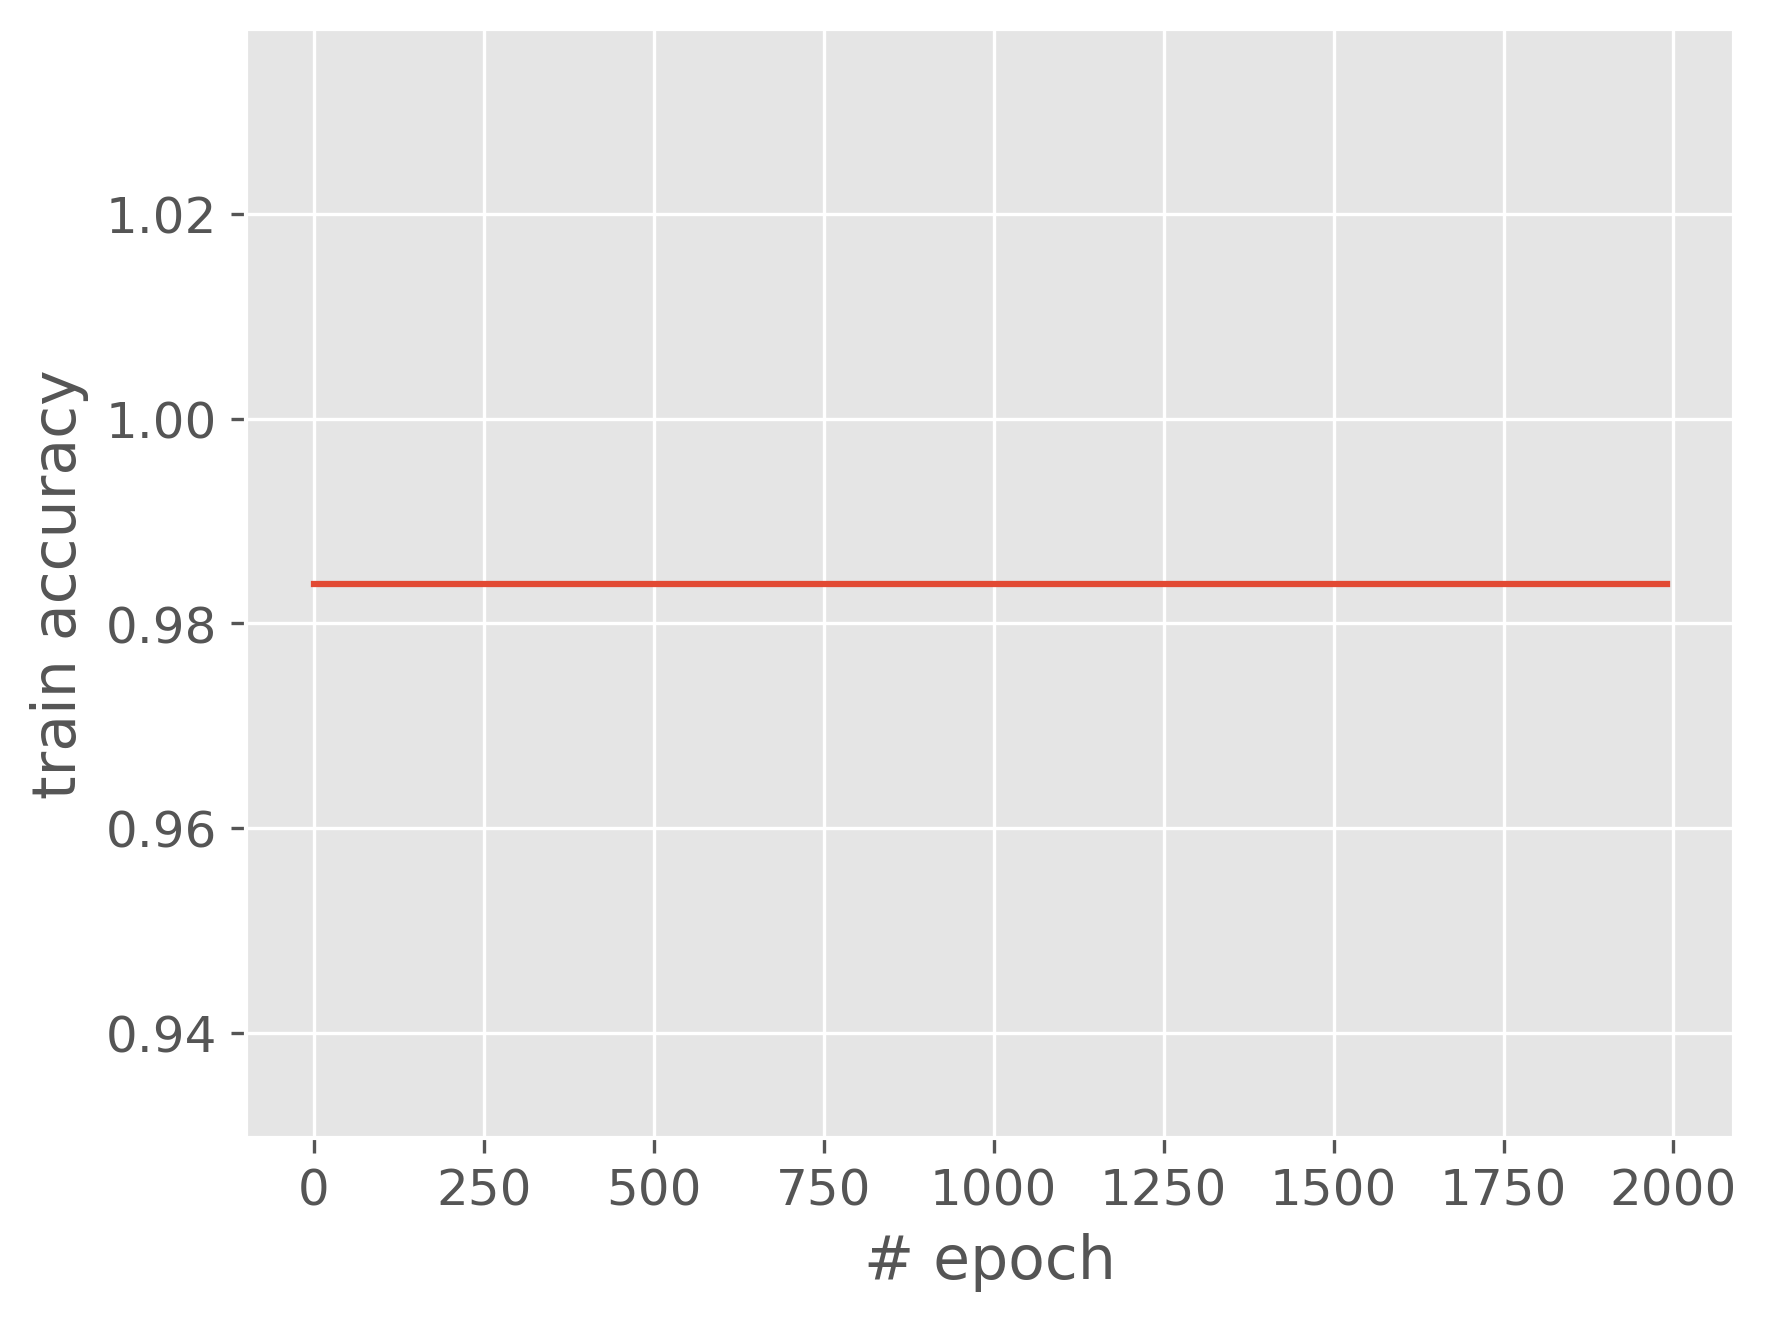

In [26]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13

plt.plot(list(train_acc.keys()), list(train_acc.values()))
plt.xlabel("# epoch")
plt.ylabel("train accuracy")
plt.savefig("LSTM-64_parity_train_accuracy.png")
plt.show()

In [24]:
from driver_parity import runParityExperiment

runParityExperiment(model,maximum_training_sequence_length)

2023-02-08 16:23:39 INFO     Starting parity experiment with model: LSTM-64
2023-02-08 16:23:39 INFO     Evaluating over strings of length 1-20.
2023-02-08 16:23:39 INFO     length=1 val accuracy 1.000
2023-02-08 16:23:39 INFO     length=2 val accuracy 1.000
2023-02-08 16:23:39 INFO     length=3 val accuracy 1.000
2023-02-08 16:23:39 INFO     length=4 val accuracy 1.000
2023-02-08 16:23:39 INFO     length=5 val accuracy 0.969
2023-02-08 16:23:39 INFO     length=6 val accuracy 0.906
2023-02-08 16:23:39 INFO     length=7 val accuracy 0.773
2023-02-08 16:23:39 INFO     length=8 val accuracy 0.672
2023-02-08 16:23:39 INFO     length=9 val accuracy 0.582
2023-02-08 16:23:39 INFO     length=10 val accuracy 0.548
2023-02-08 16:23:39 INFO     length=11 val accuracy 0.521
2023-02-08 16:23:39 INFO     length=12 val accuracy 0.509
2023-02-08 16:23:40 INFO     length=13 val accuracy 0.504
2023-02-08 16:23:41 INFO     length=14 val accuracy 0.501
2023-02-08 16:23:43 INFO     length=15 val accuracy 

### Embedded Reber Grammers: Thinking About Memory

# Part-of-Speech Tagging